# Анализ развлекательного приложения Procrastinate Pro+

**Предмет исследования**: развлекательное приложение Procrastinate Pro+. 

**Проблематика**: несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. 

**Цель исследования**: разобраться в причинах убыточности рекламы и помочь компании выйти в плюс.

**Исходные данные** о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
- лог сервера с данными об их посещениях,
- выгрузка их покупок за этот период,
- рекламные расходы.

**Необходимо изучить**:
- откуда приходят пользователи и какими устройствами они пользуются,
- сколько стоит привлечение пользователей из различных рекламных каналов;
- сколько денег приносит каждый клиент,
- когда расходы на привлечение клиента окупаются,
- какие факторы мешают привлечению клиентов.

## Загрузка и обзор сырых данных

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# Загружаем данные о визитах
visits = pd.read_csv('/datasets/visits_info_short.csv')
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [3]:
visits.head(3)

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08


In [4]:
# Загружаем данные о заказах
orders = pd.read_csv('/datasets/orders_info_short.csv')
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [5]:
orders.head(3)

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99


In [6]:
# Загружаем данные о расходах
costs = pd.read_csv('/datasets/costs_info_short.csv')
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [7]:
costs.head(3)

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8


Из выведенной информации по трем датасетам, обнаружены следующие проблемы:
 - Нарушение хорошего стиля в названиях столбцов. Поэтому необходимо их привести к единому стилю.
 - Необходимо будет изменить тип данных в некторых столбцах - сделаем это на этапе предобработки/
 - Пропуски не обнаружены

## Предобработка данных

### Приведение названия столбцов к единому стилю

In [8]:
# Выведем перечень названий столбцов таблицы visits
visits.columns

Index(['User Id', 'Region', 'Device', 'Channel', 'Session Start',
       'Session End'],
      dtype='object')

In [9]:
# Переименуем столбцы
visits = visits.rename(columns={'User Id': 'user_id', 'Region' : 'region', 'Device' : 'device', 'Channel' : 'channel', 'Session Start' : 'session_start', 'Session End' : 'session_end'})
visits.columns

Index(['user_id', 'region', 'device', 'channel', 'session_start',
       'session_end'],
      dtype='object')

In [10]:
# Выведем перечень названий столбцов таблицы orders
orders.columns

Index(['User Id', 'Event Dt', 'Revenue'], dtype='object')

In [11]:
# Переименуем столбцы
orders = orders.rename(columns={'User Id': 'user_id', 'Event Dt' : 'event_dt', 'Revenue' : 'revenue'})
orders.columns

Index(['user_id', 'event_dt', 'revenue'], dtype='object')

In [12]:
# Выведем перечень названий столбцов таблицы costs
costs.columns

Index(['dt', 'Channel', 'costs'], dtype='object')

In [13]:
# Переименуем столбцы
costs = costs.rename(columns={'Channel': 'channel'})
costs.columns

Index(['dt', 'channel', 'costs'], dtype='object')

### Изменение типов данных

In [14]:
# Преобразуем данные о времени
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date 

### Обработка дубликатов

In [15]:
# Проверим наличие полных дубликатов, т.е. дубликатов по всем столбцам одновременно в visits
visits.duplicated().sum()

0

In [16]:
# Проверим наличие полных дубликатов, т.е. дубликатов по всем столбцам одновременно в orders
orders.duplicated().sum()

0

In [17]:
# Проверим наличие полных дубликатов, т.е. дубликатов по всем столбцам одновременно в costs
costs.duplicated().sum()

0

In [18]:
visits['channel'].value_counts() 

organic               107760
TipTop                 54794
FaceBoom               49022
WahooNetBanner         20465
LeapBob                17013
OppleCreativeMedia     16794
RocketSuperAds         12724
YRabbit                 9053
MediaTornado            8878
AdNonSense              6891
lambdaMediaAds          6507
Name: channel, dtype: int64

In [19]:
costs['channel'].value_counts() 

OppleCreativeMedia    180
WahooNetBanner        180
MediaTornado          180
RocketSuperAds        180
TipTop                180
YRabbit               180
AdNonSense            180
FaceBoom              180
LeapBob               180
lambdaMediaAds        180
Name: channel, dtype: int64

Дубликаты в датафреймах не обнаружены

### Подготовка функций для проведения анализа

#### Функция для создания профилей пользователей

In [20]:
# Зададим функцию для создания пользовательских профилей

def get_profiles(visits, orders, costs, event_names=[]):

    # находим параметры первых посещений
    profiles = (
        visits.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].values.astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # добавляем флаги для всех событий из event_names
    for event in event_names:
        if event in events['event_name'].unique():
            profiles[event] = profiles['user_id'].isin(
                events.query('event_name == @event')['user_id'].unique()
            )

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    costs = costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    costs['acquisition_cost'] = costs['costs'] / costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

#### Функция для подсчёта Retention Rate

In [21]:
# Зададим функцию для расчёта удержания

def get_retention(
    profiles,
    visits,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        visits[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

#### Функция  для подсчёта конверсии

In [22]:
 # Зададим функцию для расчёта конверсии

def get_conversion(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_orders = (
        orders.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_orders[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

#### Функция для подсчёта LTV

In [23]:
# Зададим функцию для расчёта LTV и ROI

def get_ltv(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        orders[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

#### Функция для сглаживания данных

In [24]:
# Зададим функцию для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

#### Функция для построения графика Retention Rate

In [25]:
# Зададим функцию для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

#### Функция  для построения графика конверсии

In [26]:
# Зададим функцию для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

#### Функция для визуализации LTV и ROI

In [27]:
# Зададим функцию для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

### Выводы

- Названия всех столбцов приведены к единому стилю
- Стобцы с датой приведены к соответствующему типу
- Дубликаты в данных не обнаружены
- Подготовлены функции для дальнейшего анализа данных

## Исследовательский анализ данных

###  Профили пользователей

Составим профили пользователей. Определим минимальную и максимальную даты привлечения пользователей.

In [28]:
# Составим профили пользователей
profiles = get_profiles(visits, orders, costs)
display(profiles.head(5))

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [29]:
# Определим минимальную и максимальную даты привлечения пользователей.
min_analysis_date = profiles['dt'].min()
max_analysis_date = profiles['dt'].max()
print(f'Минимальная дата привлечения пользователей {min_analysis_date.strftime("%Y-%m-%d")}, максимальная {max_analysis_date.strftime("%Y-%m-%d")}')

Минимальная дата привлечения пользователей 2019-05-01, максимальная 2019-10-27


### Распределение пользователей по странам

Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.

In [30]:
# Выясним из каких стран больше всего платящих пользователей
profiles_region = (
    profiles.groupby('region')[['user_id', 'payer']]
    .agg({'user_id': 'count', 'payer':'sum'}).reset_index()
)

total_users = profiles_region['user_id'].sum()
print('Всего пользователей: ', total_users)

# В какой стране наибольшая доля платящих пользователей
# Доля пользователей в каждом регионе
profiles_region['region%'] = round(profiles_region['user_id'] / total_users * 100, 2)
# Доля платящих пользователей в регионе относительно количества пользователй в этом регионе
profiles_region['payers%'] = round(profiles_region['payer'] / profiles_region['user_id'] * 100, 2)
profiles_region.sort_values(by='payers%', ascending=False)

Всего пользователей:  150008


,region,user_id,payer,region%,payers%
3,United States,100002,6902,66.66,6.90
1,Germany,14981,616,9.99,4.11
2,UK,17575,700,11.72,3.98
0,France,17450,663,11.63,3.80


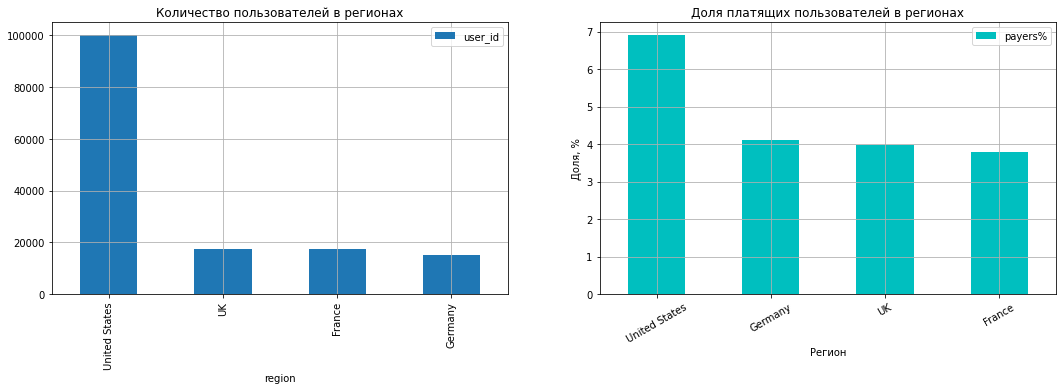

In [31]:
# Отобразим полученные данные на графиках
plt.figure(figsize=(18, 5))

# Количество пользователей в регионах
ax1 = plt.subplot(1, 2, 1)
profiles_region.sort_values(by='user_id', ascending=False).plot.bar(
    x='region', y=['user_id'], grid=True,
    title='Количество пользователей в регионах', ax=ax1
).set(ylabel=None)


# Доля платящих пользователей внутри каждого региона
ax2 = plt.subplot(1, 2, 2)
profiles_region.sort_values(by='payers%', ascending=False).plot.bar(
    x='region', y=['payers%'], grid=True,
    title='Доля платящих пользователей в регионах',
    rot=30, color='c', ax=ax2
).set(xlabel='Регион', ylabel='Доля, %')
plt.show()

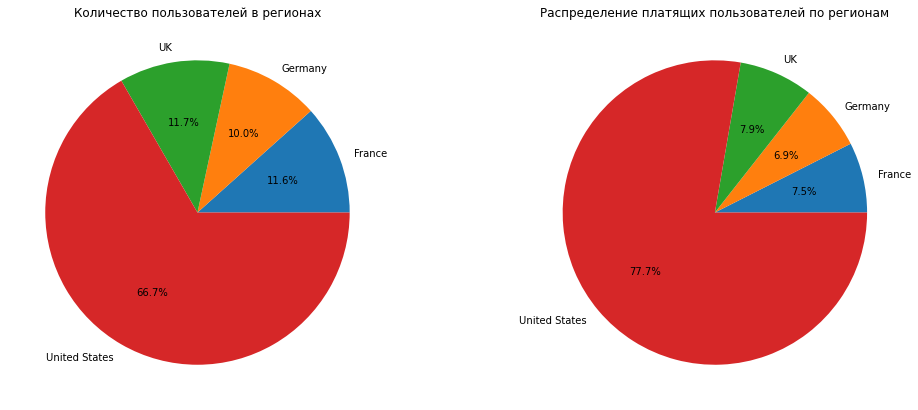

In [32]:
fig, ax = plt.subplots(1, 2, figsize = (17, 7),  squeeze=False)

# Количество пользователей в регионах
ax[0][0].pie(profiles_region.user_id, labels=profiles_region.region, autopct='%1.1f%%')
ax[0][0].set(title='Количество пользователей в регионах')

# Распределение платящих пользователей по регионам
ax[0][1].pie(profiles_region.payer, labels=profiles_region.region, autopct='%1.1f%%')
ax[0][1].set(title='Распределение платящих пользователей по регионам')

plt.show()

По выведенной информации и графикам видно, что:
- Большая часть пользователей, которые приходят в приложение, из США - 66,7%. Меньше всего пользоватлей из Германии - 10%
- Платящих пользователей больше всего приходится на США - 77,7%, меньше всего платящих пользователей приходится на Германию - 6,9%

###  Распределение пользователей по устройствам

- Изучим, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. 
- Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.

In [33]:
# Узнаем какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи
profiles_device = (
    profiles.groupby('device')[['user_id', 'payer']]
    .agg({'user_id': 'count', 'payer':'sum'}).reset_index()
)
profiles_device['payers%'] = round(profiles_device['payer'] / profiles_device['user_id'] * 100, 2)
profiles_device.sort_values(by='payers%', ascending=False)

,device,user_id,payer,payers%
1,Mac,30042,1912,6.36
3,iPhone,54479,3382,6.21
0,Android,35032,2050,5.85
2,PC,30455,1537,5.05


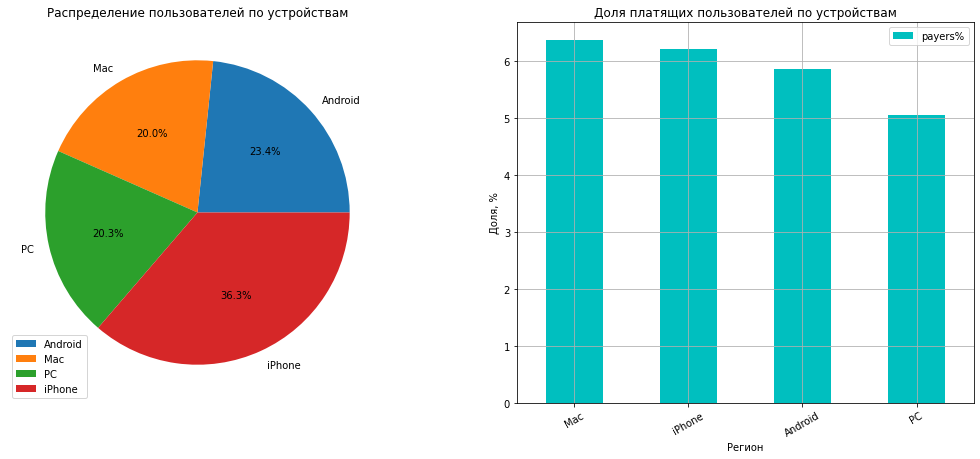

In [34]:
# Визуализируем полученные данные на графике
plt.figure(figsize=(18, 7))

# Построим круговую диаграмму распределения утсройств по всем пользователям
ax1 = plt.subplot(1, 2, 1)
profiles_device.sort_values(by='device', ascending=True).plot.pie(
    y='user_id', labels=profiles_device['device'], autopct='%1.1f%%',
    title='Распределение пользователей по устройствам', ax=ax1
).set(ylabel=None)

# Построим столбчатую диаграмму для доли платящих пользователей в рамках региона
ax2 = plt.subplot(1, 2, 2)
profiles_device.sort_values(by='payers%', ascending=False).plot.bar(
    x='device', y=['payers%'], grid=True,
    title='Доля платящих пользователей по устройствам',
    rot=30, color='c', ax=ax2
).set(xlabel='Регион', ylabel='Доля, %')
plt.show()

По графикам видно, что:
- Чаще всего клиенты используют IPhone - 36,3%, равномерно распределено количество пользователей среди устройств - PC и MAC, по 20% 
- Наибольшая доля платящих клиентов у пользователей устройства Mac - 6,36%, наименьшая у PC - 5.05%

### Распределение пользователей по источникам рекламы

- Изучим рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. 
- Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

In [35]:
# Найдем общее количество и количество платящих пользователей каждого канала, сгруппировав данные по источникам рекламы
profiles_channel = (
    profiles.groupby('channel')[['user_id', 'payer']]
    .agg({'user_id': 'count', 'payer':'sum'}).reset_index()
)

# Посчитаем долю пользователей каждого канала 
profiles_channel['users%'] = round(profiles_channel['user_id'] / profiles_channel['user_id'].sum() * 100, 2)

# Посчитаем долю платящих внутри канала
profiles_channel['payers%'] = round(profiles_channel['payer'] / profiles_channel['user_id'] * 100, 2)

profiles_channel.sort_values(by='payers%', ascending=False)

,channel,user_id,payer,users%,payers%
1,FaceBoom,29144,3557,19.43,12.20
0,AdNonSense,3880,440,2.59,11.34
9,lambdaMediaAds,2149,225,1.43,10.47
6,TipTop,19561,1878,13.04,9.60
5,RocketSuperAds,4448,352,2.97,7.91
7,WahooNetBanner,8553,453,5.70,5.30
8,YRabbit,4312,165,2.87,3.83
3,MediaTornado,4364,156,2.91,3.57
2,LeapBob,8553,262,5.70,3.06
4,OppleCreativeMedia,8605,233,5.74,2.71


- Наибольшее количество пользователей дают каналы organic, FaceBoom и TipTop
- Максимальная конверсия в платящих пользователей приходится на каналы FaceBoom, AdNonSense и lambdaMediaAds

### Выводы

- Подготовили профили пользователей
- Минимальная дата привлечения пользователей 2019-05-01, максимальная 2019-10-27
- Большая часть пользователей, которые приходят в приложение, из США - 66,7%. Меньше всего пользоватлей из Германии - 10%
- Платящих пользователей больше всего приходится на США - 77,7%, меньше всего платящих пользователей приходится на Германию - 6,9%
- Чаще всего клиенты используют IPhone - 36,3%, равномерно распределено количество пользователей среди устройств - PC и MAC, по 20%
- Наибольшая доля платящих клиентов у пользователей устройства Mac - 6,36%, наименьшая у PC - 5.05%
- Наибольшее количество пользователей дают каналы organic, FaceBoom и TipTop
- Максимальная конверсия в платящих пользователей приходится на каналы FaceBoom, AdNonSense и lambdaMediaAds

## Маркетинг

### Общая сумма расходов на маркетинг

In [36]:
# Посчитаем общую сумму расходов на маркетинг
total_costs = costs['costs'].sum()
print(f'Общая сумма расходов на маркетинг: {total_costs:10.2f}')

Общая сумма расходов на маркетинг:  105497.30


### Распределение расходов по источникам рекламы

Выясним, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.

In [37]:
# Выясним сколько  денег потратили на каждый источник
costs_chanel = costs.pivot_table(index='channel', values='costs', aggfunc='sum').sort_values('costs', ascending=False) \
     .reset_index()
costs_chanel['costs_chanel%'] = costs_chanel.costs / costs_chanel.costs.sum() * 100
display(costs_chanel)

,channel,costs,costs_chanel%
0,TipTop,54751.30,51.898295
1,FaceBoom,32445.60,30.754910
2,WahooNetBanner,5151.00,4.882589
3,AdNonSense,3911.25,3.707441
4,OppleCreativeMedia,2151.25,2.039152
5,RocketSuperAds,1833.00,1.737485
6,LeapBob,1797.60,1.703930
7,lambdaMediaAds,1557.60,1.476436
8,MediaTornado,954.48,0.904744
9,YRabbit,944.22,0.895018


Из выведенной информации можно сделать следующий вывод:
- больше всего денег потратили на такие каналы привлечения, как - TipTop и FaceBoom
- затраты на привлечение пользователей с остальных источников оказались гораздо меньше
- минимальный бюджет был выделен на источник "YRabbit"

### Анализ динамики изменения расходов по источникам и по времени

- Построим график с визуализацией динамики изменения расходов во времени по неделям по каждому источнику. 
- Затем на другом графике визуализируем динамику изменения расходов во времени по месяцам по каждому источнику.

In [38]:
# Построим график с визуализацией динамики изменения расходов по каждому источнику во времени по неделям и месяцам
pivot_channel_date = costs.reset_index().pivot_table(index='dt', columns='channel', values='costs', aggfunc='sum')
pivot_channel_date.head()

channel,AdNonSense,FaceBoom,LeapBob,MediaTornado,OppleCreativeMedia,RocketSuperAds,TipTop,WahooNetBanner,YRabbit,lambdaMediaAds
dt,,,,,,,,,,
2019-05-01,40.95,113.3,2.52,6.24,4.25,21.060,80.0,10.8,8.1,17.6
2019-05-02,34.65,78.1,2.94,5.04,4.25,16.965,55.0,7.2,9.9,16.8
2019-05-03,47.25,85.8,2.73,6.96,5.75,16.380,64.0,8.4,9.0,16.8
2019-05-04,51.45,136.4,3.99,9.36,4.25,17.550,70.0,10.8,15.6,17.6
2019-05-05,36.75,122.1,4.62,11.04,5.50,27.495,78.0,12.0,9.6,12.8


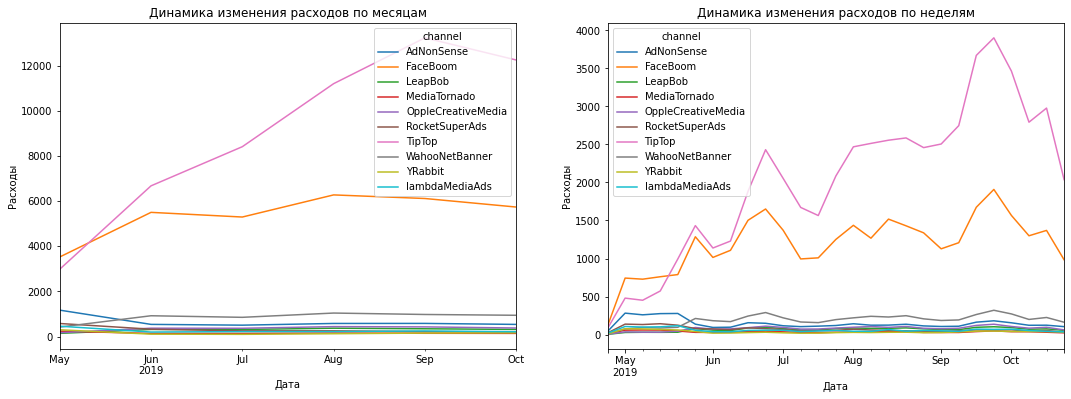

In [39]:
# Построим график с визуализацией динамики изменения расходов по каждому источнику во времени по неделям и месяцам

# cтолбец с датой в формате месяц
costs['month'] = costs['dt'].astype('datetime64[M]')

# cтолбец с датой в формате неделя
costs['week'] = costs['dt'].astype('datetime64[W]')

columns = ['month', 'week']
plt.subplots(figsize = (18, 6))

costs.pivot_table(index='month', columns='channel', values='costs', aggfunc='sum').plot(
    ax = plt.subplot(1, 2, 1),
    title='Динамика изменения расходов по месяцам'
).set(    
    xlabel='Дата',
    ylabel='Расходы'
)
  
costs.pivot_table(index='week', columns='channel', values='costs', aggfunc='sum').plot(
    ax = plt.subplot(1, 2, 2),
    title='Динамика изменения расходов по неделям'
).set(
    xlabel='Дата',
    ylabel='Расходы'
)
  
plt.show() 

Из графиков видно:
- компания сделала ставку на привлечение пользователей через каналы TipTop и FaceBoom
- пиковые расходы пришлись на периоды вторая половина июня и сентября
- остальные каналы получили миниммальные бюджеты и траты на них практически не меняются

### Анализ стоимости привлечения одного пользователя

Изучим, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. 
Для этого будем использовать профили пользователей.

In [40]:
# Посчитаем средний САС по всем пользователям платных каналов (т.е. без канала Organic)
profiles_mean_ac = round(profiles.query('channel != "organic"')['acquisition_cost'].mean(), 2)
print(profiles_mean_ac)

1.13


In [41]:
# Рассчитаем САС на одного пользователя
costs_mean_ac = profiles.groupby('channel').agg(
    {'acquisition_cost': 'mean'}
).sort_values(by='acquisition_cost', ascending=False).reset_index()
costs_mean_ac

,channel,acquisition_cost
0,TipTop,2.799003
1,FaceBoom,1.113286
2,AdNonSense,1.008054
3,lambdaMediaAds,0.724802
4,WahooNetBanner,0.602245
5,RocketSuperAds,0.412095
6,OppleCreativeMedia,0.250000
7,YRabbit,0.218975
8,MediaTornado,0.218717
9,LeapBob,0.210172


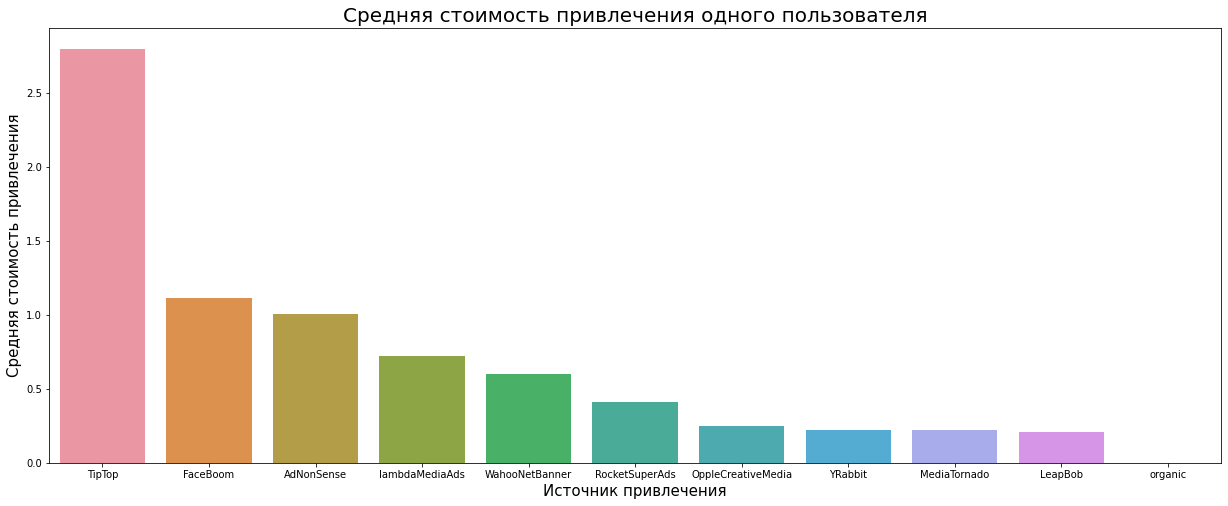

In [42]:
# Отобразим полученные данные на графике
plt.figure(figsize=(21,8))
plt.title('Средняя стоимость привлечения одного пользователя', fontsize=20)
sns.barplot(data=costs_mean_ac, x='channel', y='acquisition_cost')
plt.xlabel('Источник привлечения', fontsize=15)
plt.ylabel('Средняя стоимость привлечения', fontsize=15);

- Самыми дорогими по стоимости оказались пользователи, привлеченные через канал TipTop - средняя цена 2,8 доллар за одного пользователя.
- Практически в одинаковую цену обходятся пользователи, привлеченные через источники FaceBoom и AdNonSense - средняя цена 1,1 и 1 доллар за одного пользователя.
- В самую меньшую стоимость обходятся пользователи, привлеченные через канал LeapBob - 0,21 доллар за одного.

### Выводы

- Общая сумма расходов на маркетинг:  $105497.30
- больше всего денег потратили на такие каналы привлечения, как - TipTop и FaceBoom
- затраты на привлечение пользователей с остальных источников оказались гораздо меньше
- минимальный бюджет был выделен на источник "YRabbit"
- компания сделала ставку на привлечение пользователей через каналы TipTop и FaceBoom
- пиковые расходы пришлись на периоды вторая половина июня и сентября
- остальные каналы получили миниммальные бюджеты и траты на них практически не меняются
- Посчитаем средний САС по всем пользователям платных каналов - 1,3
- Самыми дорогими по стоимости оказались пользователи, привлеченные через канал TipTop - средняя цена 2,8 доллар за одного пользователя.
- Практически в одинаковую цену обходятся пользователи, привлеченные через источники FaceBoom и AdNonSense - средняя цена 1,1 и 1 доллар за одного пользователя.
- В самую меньшую стоимость обходятся пользователи, привлеченные через канал LeapBob - 0,21 доллар за одного.

## Анализ окупаемости рекламы

- Используя графики LTV, ROI и CAC, проанализируем окупаемость рекламы. 
- Считаем, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. 
- Исключим из анализа органических пользователей.

In [43]:
# Зададим момент анализа
observation_date = datetime(2019, 11, 1).date()

# Зададим горизонт анализа
analysis_horizon = 14

### Общий анализ окупаемости рекламы

Проанализируем окупаемость рекламы c помощью графиков LTV и ROI, а также графиков динамики LTV, CAC и ROI.

In [44]:
# Исключим всех пользователей из источника organic
profiles_wo_org = profiles.query('channel != "organic"') 

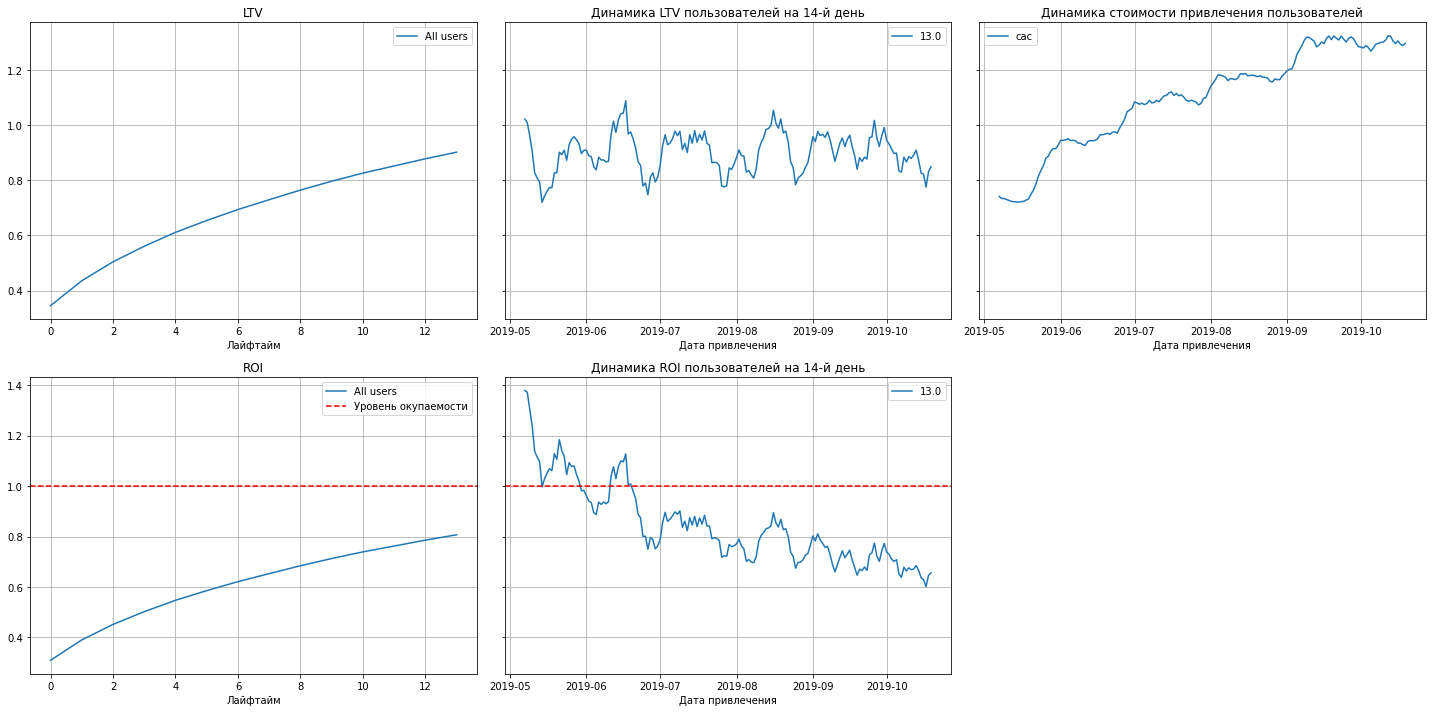

In [45]:
# Рассчитаем и визуализируем LTV и ROI, вызвав функции get_ltv() и plot_ltv_roi()
# Посчитаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_wo_org, orders, observation_date, analysis_horizon
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, analysis_horizon) 

По графикам можно сделать следующие выводы:
- LTV растет на протяжении всего рассматриваемого периода, значит качество пользователей примерно на одном уровне. Это хороший показатель.
- Однако реклама все равно не окупается, и к концу второй недели уровень окупаемости достигает всего лишь 80%
- На графике динамики LTV наблюдаются подъемы и спады, видимо оказывает влияние сезонный фактор
- Показатель САС на протяжении всего периода растет, а показатель ROI снижается

### Анализ удержания и конверсии пользователей

- Проверим конверсию пользователей и динамику её изменения. 
- То же самое сделаем с удержанием пользователей. 
- Построим и изучим графики конверсии и удержания.

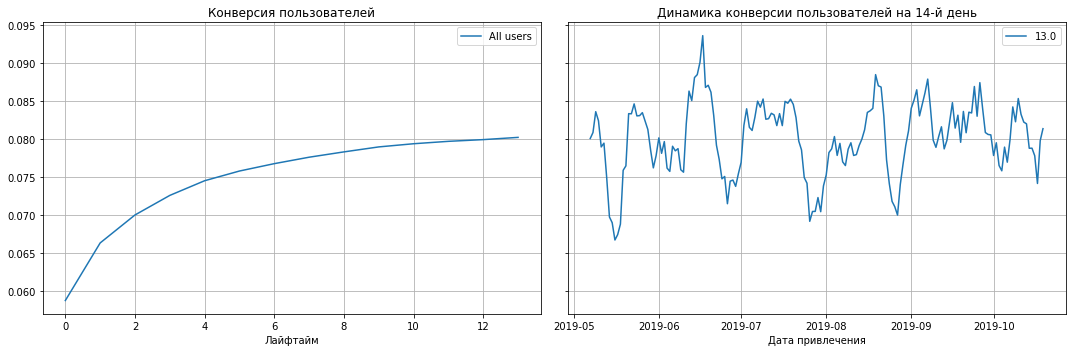

In [46]:
# Посмотрим конверсию, передав функции get_conversion нужные датасеты, момент и горизонт анализа
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_wo_org, orders, observation_date, analysis_horizon
)
plot_conversion(conversion_grouped, conversion_history, analysis_horizon)

- Первые четыре дня лайфтайма конверсия стремительно растет, затем рост замедляется.  
- В целом конверсия пользователей постепенно растёт на протяжении всего периода и выходит на отметку 8%.
- Конверсия на 14й день в динамике имеет скочкообразный характер, где амплитуда скачков изменяется от 7% до 9% 

,cohort_size,0,1,2,3,4,5,6,7,8,9,10,11,12,13
payer,,,,,,,,,,,,,,,
False,81334,1.0,0.176876,0.086594,0.051823,0.033504,0.024701,0.018651,0.014188,0.011729,0.009541,0.007488,0.006393,0.006012,0.004709
True,7310,1.0,0.380985,0.293023,0.235568,0.210260,0.191245,0.166758,0.156908,0.145144,0.136389,0.135021,0.121888,0.118741,0.104925


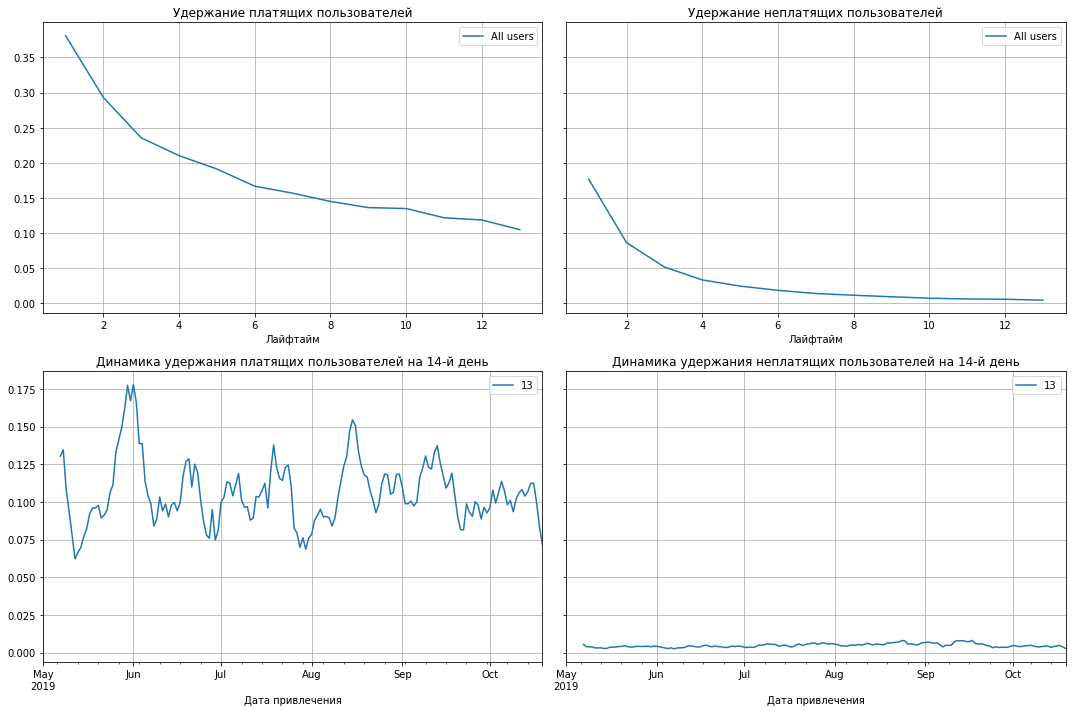

In [47]:
# Посмотрим удержание, передав функции get_retention нужные датасеты, момент и горизонт анализа
retention_raw, retention_grouped, retention_history = get_retention(profiles_wo_org, visits, observation_date, analysis_horizon)

# Выведем на экран таблицу удержания
display(retention_grouped) 

# Построим графики для платящих и неплатящих пользователей
plot_retention(retention_grouped, retention_history, analysis_horizon)

- В первый день лайтайма удержание платящих пользователей составляет около 40%. Затем этот показатель падает, и к 14-му дню составляет активных платящих пользоватетей остается лишь 10%. 
- Пик удержания платящих пользователей приходится на июнь 2019 года.
- График удержания неплатящих пользователей показывает, что они практически не задерживаются в приложении.

### Анализ окупаемости рекламы с разбивкой по устройствам

- Проанализируем окупаемость рекламы с разбивкой по устройствам. 
- Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

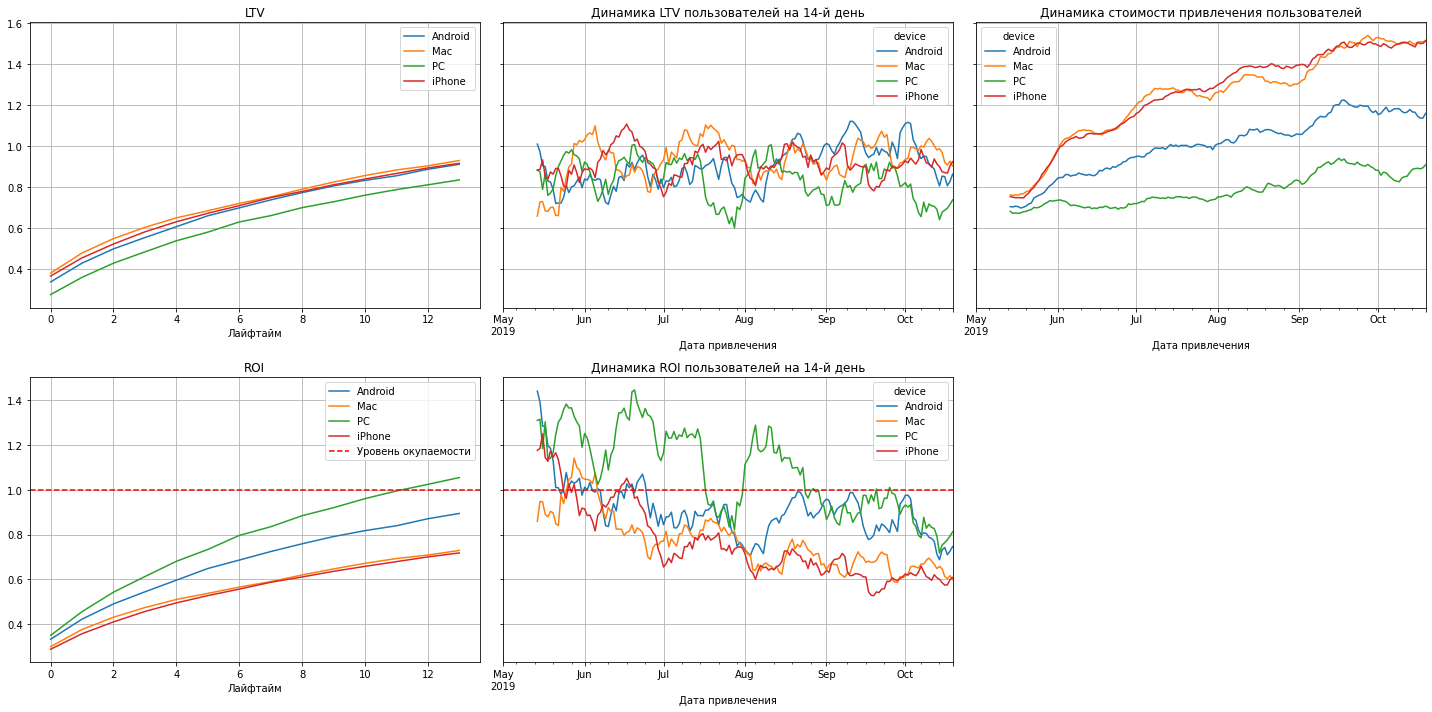

In [48]:
# Посмотрим на окупаемость с разбивкой по устройствам

dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_wo_org, orders, observation_date, analysis_horizon, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, analysis_horizon, window=14
) 

По графикам можно сделать выводы:
- LTV по всем устройствам растет на протяжении всего периода
- LTV держателей PC ниже, чем у пользователей с других устройств (если смотреть на динамику LTV), однако только с этого устройства пользователи окупались самый длительный период 
- Самая низкая стоимость привлечения поользователей у владельцев PC устройств
- Дороже всего приложению обходятся пользователи iPhone и по окупаемости у них самый худший показатель

### Анализ окупаемости рекламы с разбивкой по странам

- Проанализируем окупаемость рекламы с разбивкой по странам. 
- Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

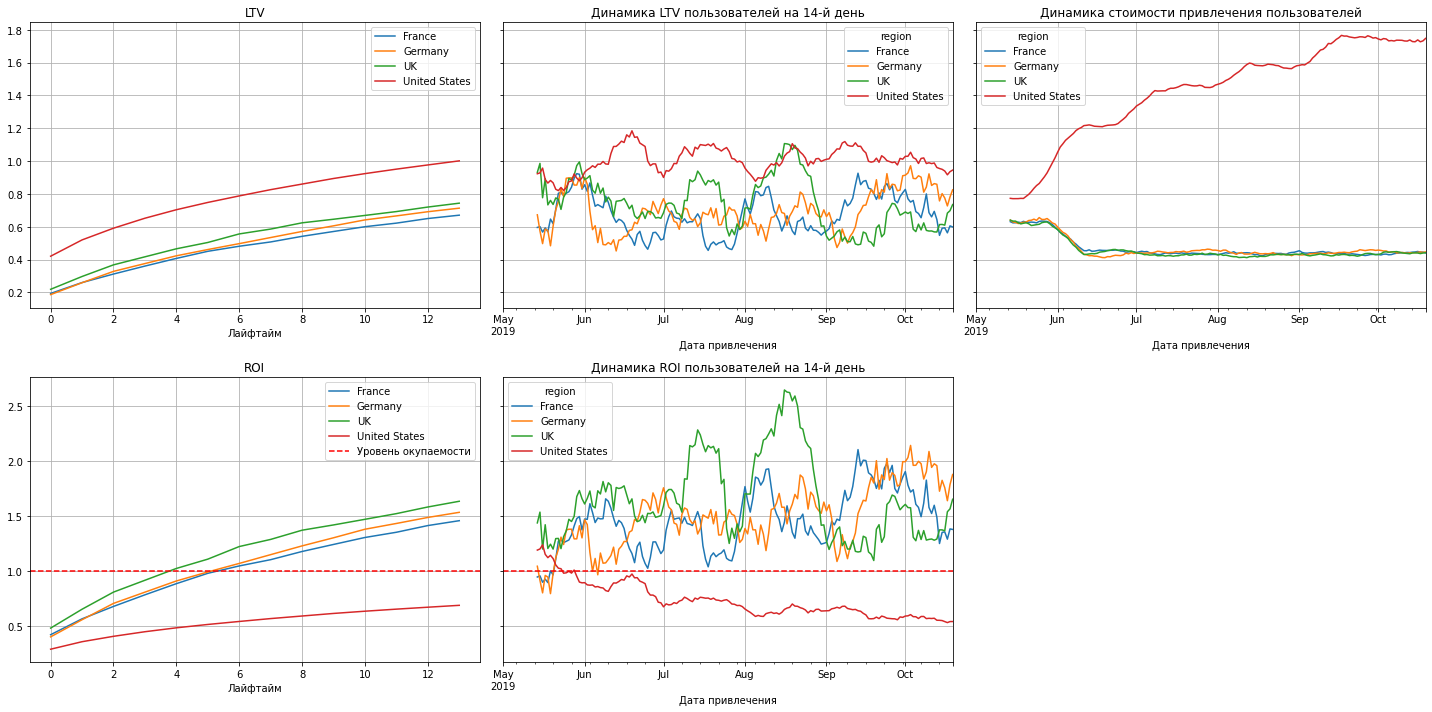

In [49]:
# Посмотрим на окупаемость с разбивкой по странам

dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_wo_org, orders, observation_date, analysis_horizon, dimensions=dimensions
)
# Построим графики
plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, analysis_horizon, window=14
) 

По графикам видно следующее:
- Рекламные расходы не окупаются лишь в США. Показатель стоимости привлечения пользователей в данной странне самый высокий и постоянно растет, несмотря на то, что это наша основная аудитория (показатель LTV у них самый высокий)
- В  остальных странах показатель САС стабилен, то есть расходы на маркетинг окупаются приблизительно за 5 дней
- Быстрее всего окупаются пользователи из UK - 4 дня, в динамике пик окупаемости пришелся на середину августа

### Анализ окупаемости рекламы с разбивкой по рекламным каналам

- Проанализируем окупаемость рекламы с разбивкой по рекламным каналам. 
- Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

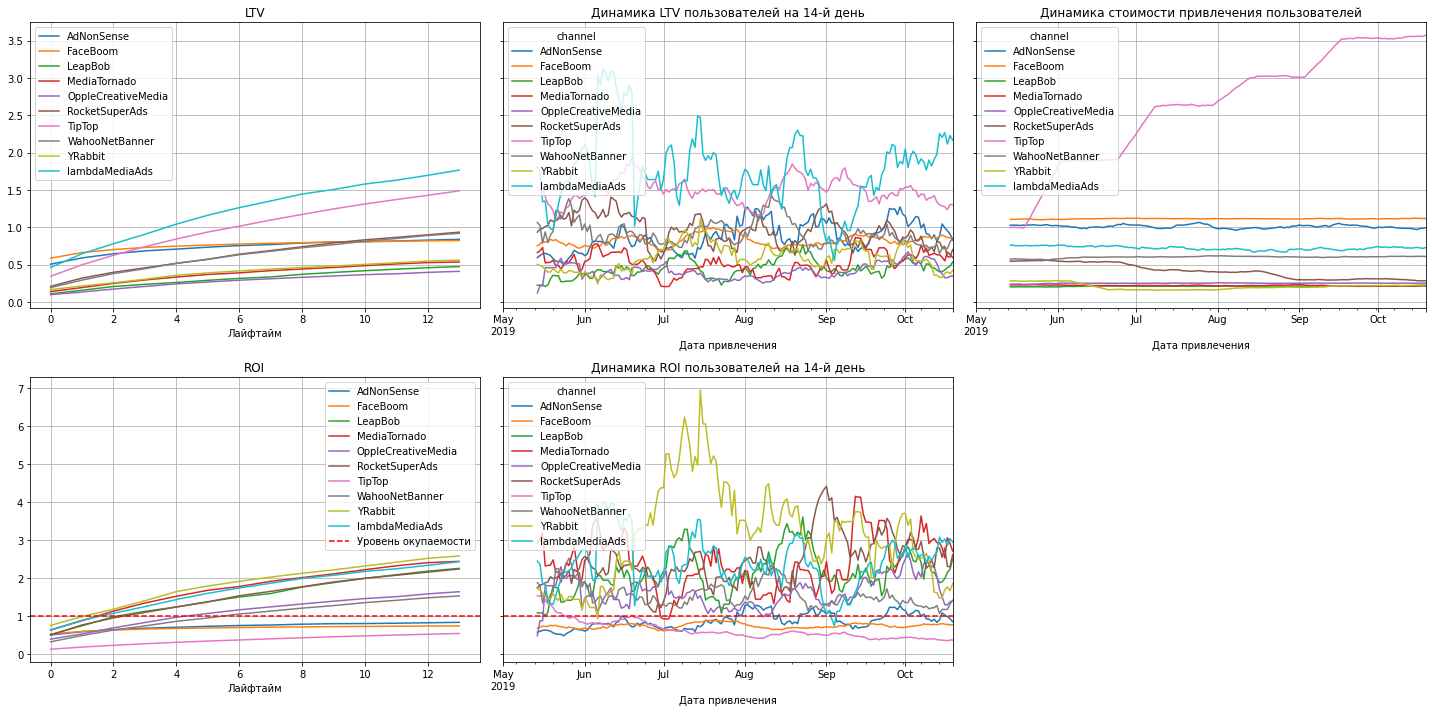

In [50]:
# Посмотрим на окупаемость с разбивкой по источникам привлечения

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_wo_org, orders, observation_date, analysis_horizon, dimensions=dimensions
)

# Построим графики
plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, analysis_horizon, window=14
) 

- У пользователей со всех рекламных каналов показатель LTV имеет положительную динамику.
- Стоимость привлечения пользователей у канала TipTop самая высокая. Также данный канал самый худший по показателю окупаемости (ROI), то есть рекламные расходы не окупаются.
- Также не окупаются пользователи, привлеченные из каналов AdNonSense и FaceBoom.
- Лучше всего окупаются пользователи, привлеченные через сеть YRabbit, пик окупаемости приходится на июль

### Анализ пользователей из США

#### Общий анализ окупаемости рекламы

In [51]:
# Выделим профили пользователей из США
profiles_wo_org_usa = profiles_wo_org.query('region == "United States"') 

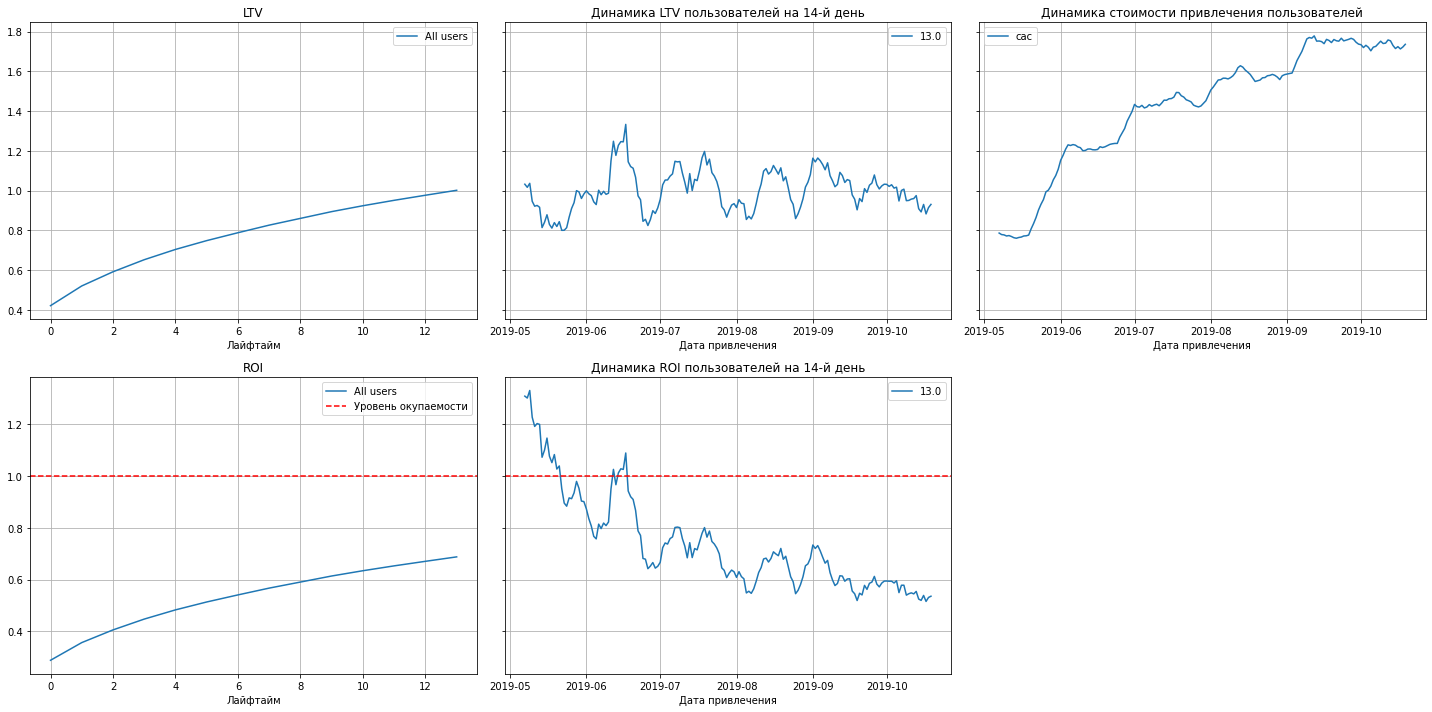

In [52]:
# Рассчитаем и визуализируем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_wo_org_usa, orders, observation_date, analysis_horizon
)
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, analysis_horizon) 

По графикам можно сделать следующие выводы:
- LTV растет на протяжении всего рассматриваемого периода, значит качество пользователей примерно на одном уровне
- ROI не дотягивает до уровня окупаемости - реклама не окупается
- Показатель САС на протяжении всего периода растет, а показатель ROI снижается

#### Анализ удержания и конверсии пользователей

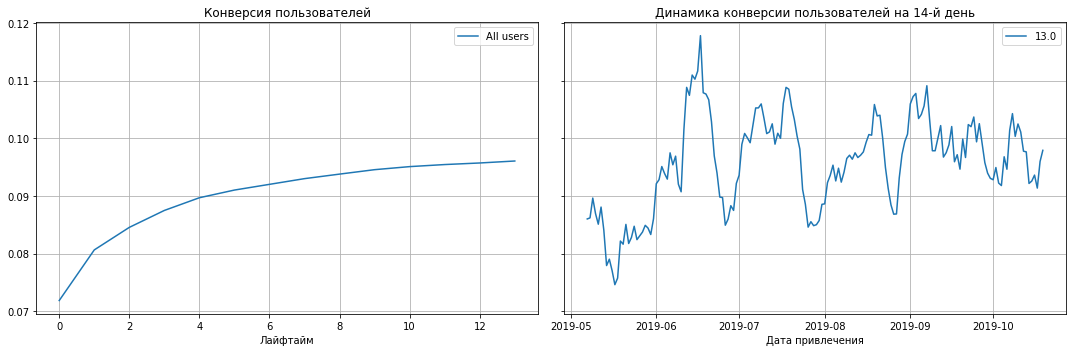

In [53]:
# Посмотрим конверсию
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_wo_org_usa, orders, observation_date, analysis_horizon
)
plot_conversion(conversion_grouped, conversion_history, analysis_horizon)

- Первые четыре дня лайфтайма конверсия стремительно растет, затем рост замедляется.  
- В целом конверсия пользователей постепенно растёт на протяжении всего периода и выходит на отметку 9,5%.
- Конверсия на 14й день в динамике имеет скочкообразный характер, где амплитуда скачков изменяется от 7% до 12% 

,cohort_size,0,1,2,3,4,5,6,7,8,9,10,11,12,13
payer,,,,,,,,,,,,,,,
False,52776,1.0,0.177221,0.085626,0.051160,0.033500,0.025030,0.018777,0.013813,0.011880,0.009474,0.007541,0.006423,0.005931,0.004301
True,5786,1.0,0.354822,0.263913,0.212755,0.183719,0.166263,0.143623,0.136018,0.125475,0.122364,0.117179,0.106982,0.103007,0.089526


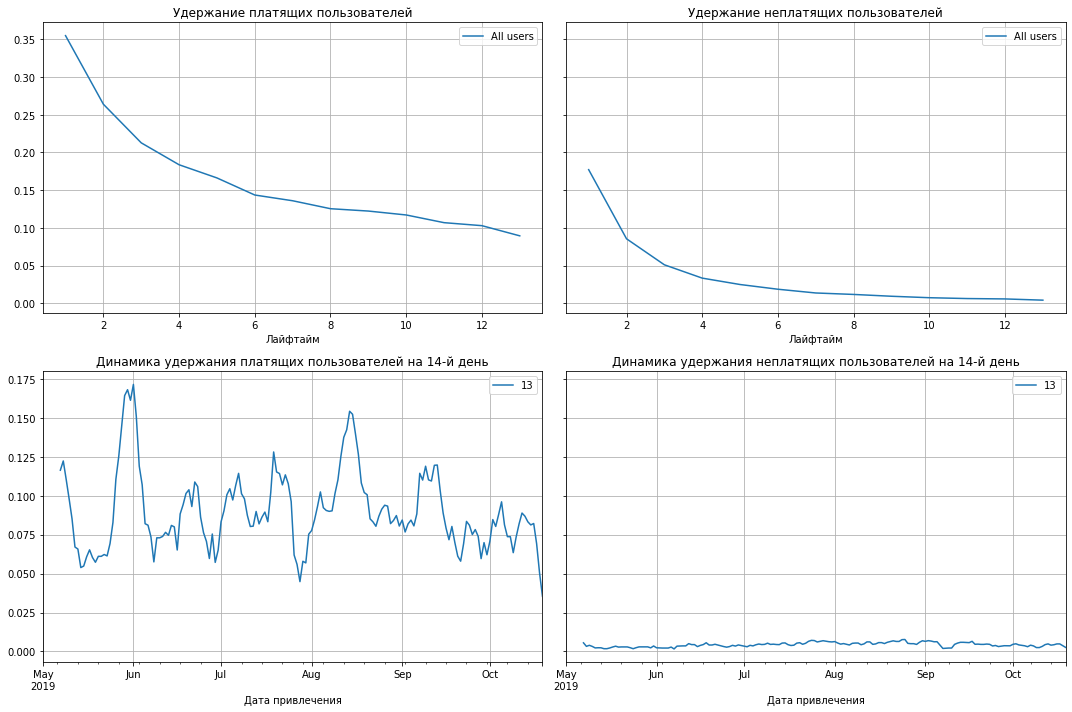

In [54]:
# Посмотрим удержание
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_wo_org_usa, visits, observation_date, analysis_horizon
)

# Выведем на экран таблицу удержания
display(retention_grouped) 

# Построим графики для платящих и неплатящих пользователей
plot_retention(retention_grouped, retention_history, analysis_horizon)

- В первый день лайтайма удержание платящих пользователей составляет около 35%. Затем этот показатель падает, и к 14-му дню составляет активных платящих пользоватетей остается лишь 9%. 
- Пик удержания платящих пользователей приходится на июнь 2019 года.
- График удержания неплатящих пользователей показывает, что они практически не задерживаются в приложении.

#### Анализ окупаемости рекламы с разбивкой по устройствам

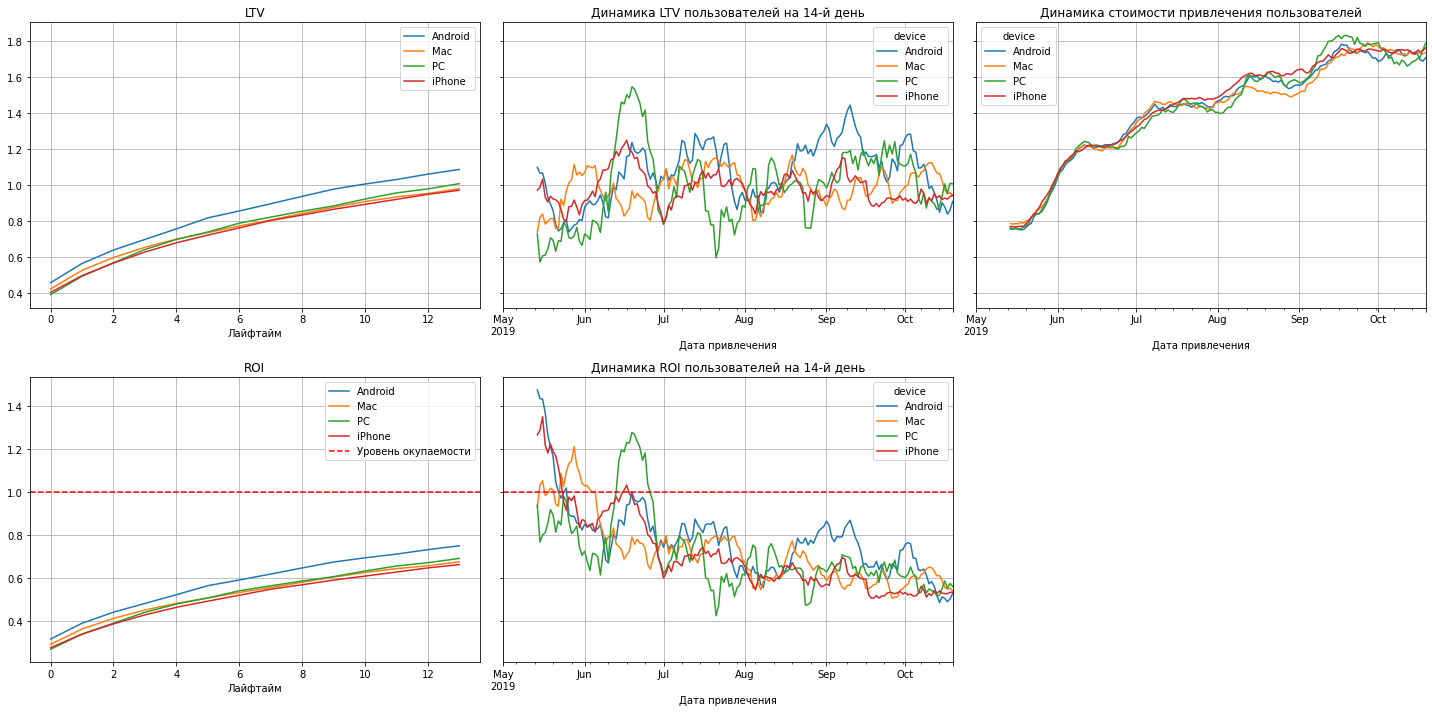

In [55]:
# Посмотрим на окупаемость с разбивкой по устройствам
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_wo_org_usa, orders, observation_date, analysis_horizon, dimensions=['device']
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, analysis_horizon, window=14
) 

По графикам можно сделать вывод, что характер показателей LTV и ROI примерно одинаковый по всем устройствам и нельзя выделить явных лидеров или аутсайдеров на общем фоне. Лишь пользователи на Android показывают незначительный перевес в лучшую сторону, но не меняют общую отрицательную картину показателей.

#### Анализ окупаемости рекламы с разбивкой по рекламным каналам

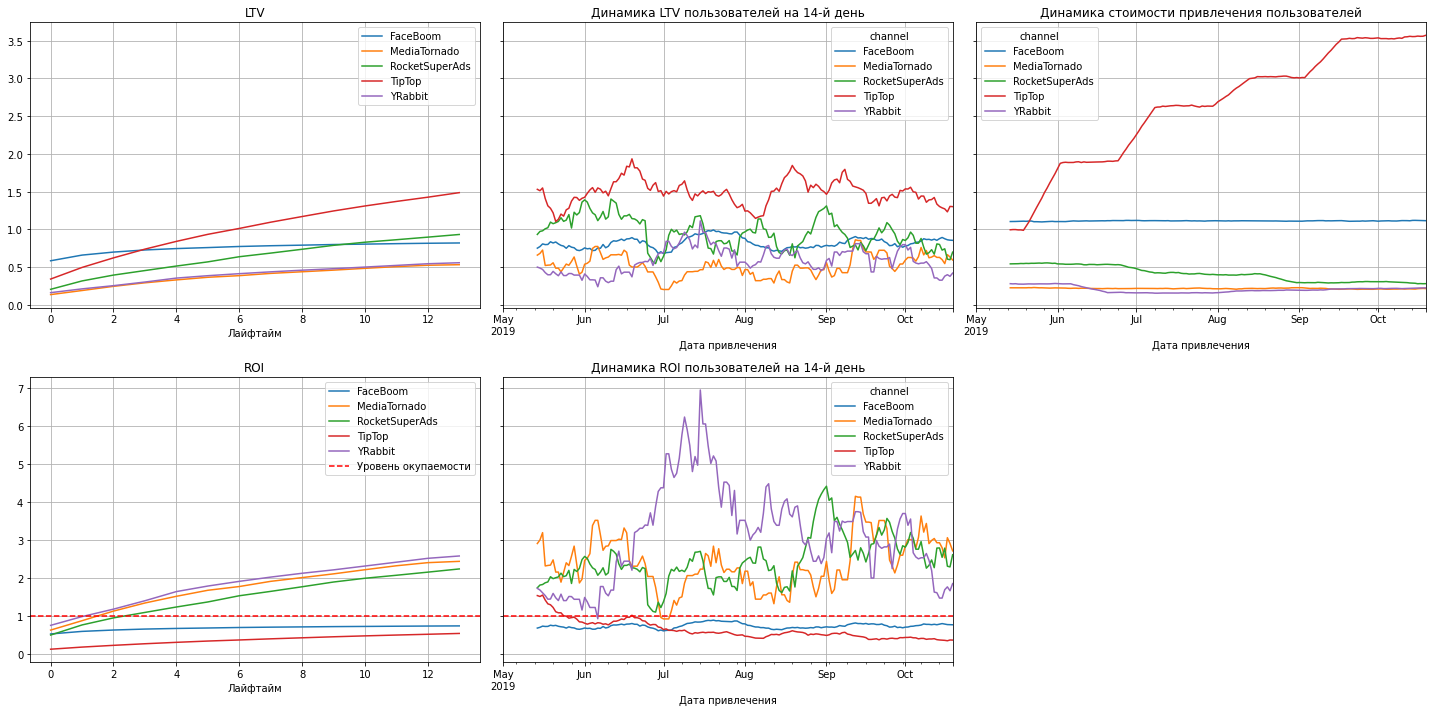

In [56]:
# Посмотрим на окупаемость с разбивкой по источникам привлечения
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_wo_org_usa, orders, observation_date, analysis_horizon, dimensions=['channel']
)

# Построим графики
plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, analysis_horizon, window=14
) 

- У пользователей со всех рекламных каналов показатель LTV имеет положительную динамику.
- Стоимость привлечения пользователей у канала TipTop самая высокая и при этом в динамике имеет стабильный рост. 
- Все каналы, кроме TipTop и FaceBoom, окупаются уже на третий день, при этом лидером можн выделить YRabbit.
- Каналы TipTop и FaceBoom не окупаются даже в динамике.

### Анализ пользователей из Европы

#### Общий анализ окупаемости рекламы

In [57]:
# Выделим профили пользователей из Европы
profiles_wo_org_europe = profiles_wo_org.query('region != "United States"') 

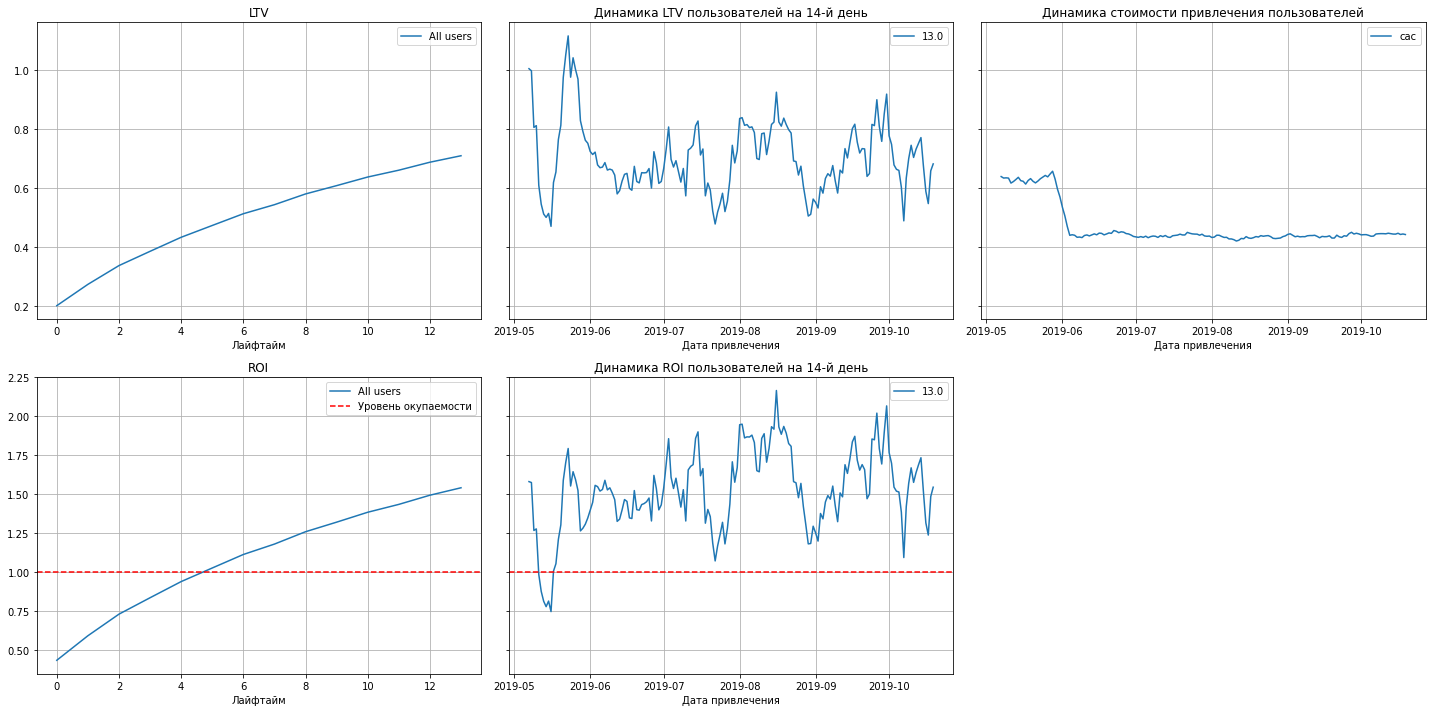

In [58]:
# Рассчитаем и визуализируем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_wo_org_europe, orders, observation_date, analysis_horizon
)
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, analysis_horizon) 

По графикам можно сделать следующие выводы:
- LTV растет на протяжении всего рассматриваемого периода, значит качество пользователей примерно на одном уровне
- Реклама окупается уже на 5й день - показатель ROI уверенно растет все 14 дней
- На графике динамики LTV наблюдаются подъемы и спады, видимо оказывает влияние сезонный фактор
- Показатель САС в июне резко упал и сохранил свое значение до конца наблюдаемомого периода

#### Анализ удержания и конверсии пользователей

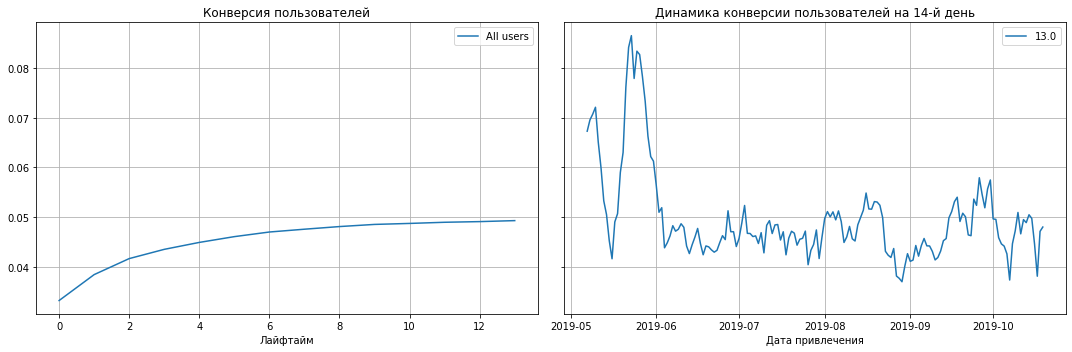

In [59]:
# Посмотрим конверсию
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_wo_org_europe, orders, observation_date, analysis_horizon
)
plot_conversion(conversion_grouped, conversion_history, analysis_horizon)

- Первые четыре дня лайфтайма конверсия стремительно растет, затем рост замедляется.  
- В целом конверсия пользователей постепенно растёт на протяжении всего периода и выходит на отметку 5%.
- Конверсия в динамике иеет скочкообразный характер, причем амплитуда скачков до июня в два раза выше, чем в оставшийся период - скорее всего это связано с резким уменьшением стоимости привлечения, показанного на предыщущих графиках

,cohort_size,0,1,2,3,4,5,6,7,8,9,10,11,12,13
payer,,,,,,,,,,,,,,,
False,28558,1.0,0.176238,0.088382,0.053050,0.033511,0.024091,0.018419,0.014882,0.011450,0.009665,0.007388,0.006338,0.006163,0.005463
True,1524,1.0,0.480315,0.403543,0.322178,0.311024,0.286089,0.254593,0.236220,0.219816,0.189633,0.202756,0.178478,0.178478,0.163386


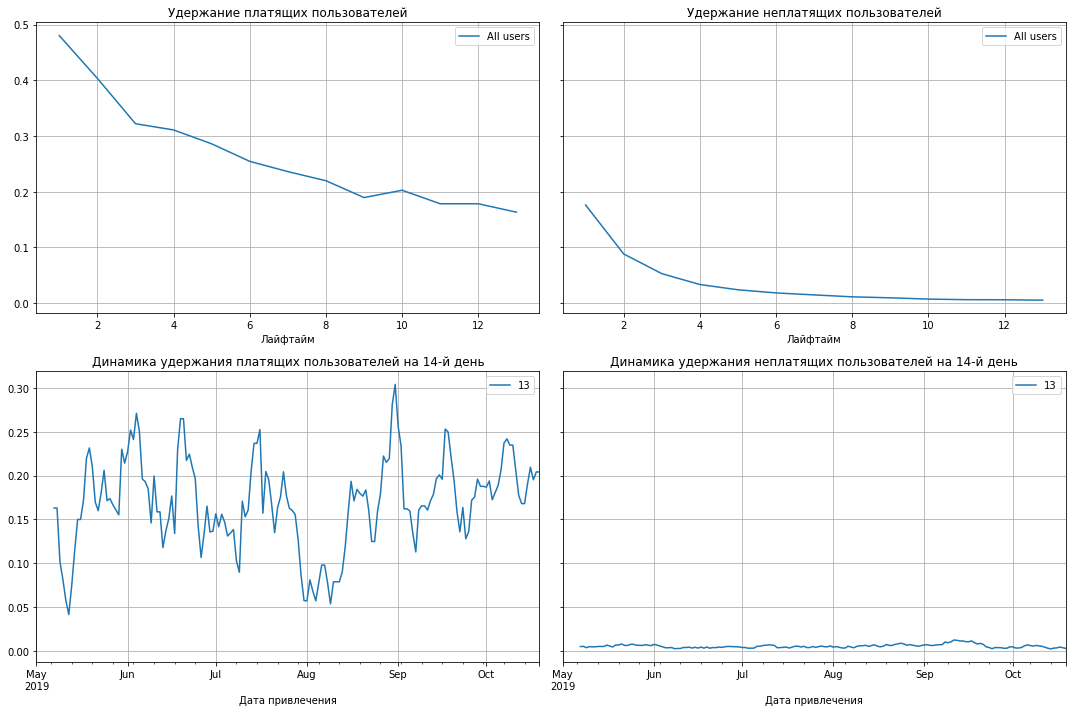

In [60]:
# Посмотрим удержание
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_wo_org_europe, visits, observation_date, analysis_horizon
)

# Выведем на экран таблицу удержания
display(retention_grouped) 

# Построим графики для платящих и неплатящих пользователей
plot_retention(retention_grouped, retention_history, analysis_horizon)

- В первый день лайтайма удержание платящих пользователей составляет около 50%. Затем этот показатель падает, и к 14-му дню составляет активных платящих пользоватетей остается 18%. 
- График удержания неплатящих пользователей показывает, что они практически не задерживаются в приложении.

#### Анализ окупаемости рекламы с разбивкой по устройствам

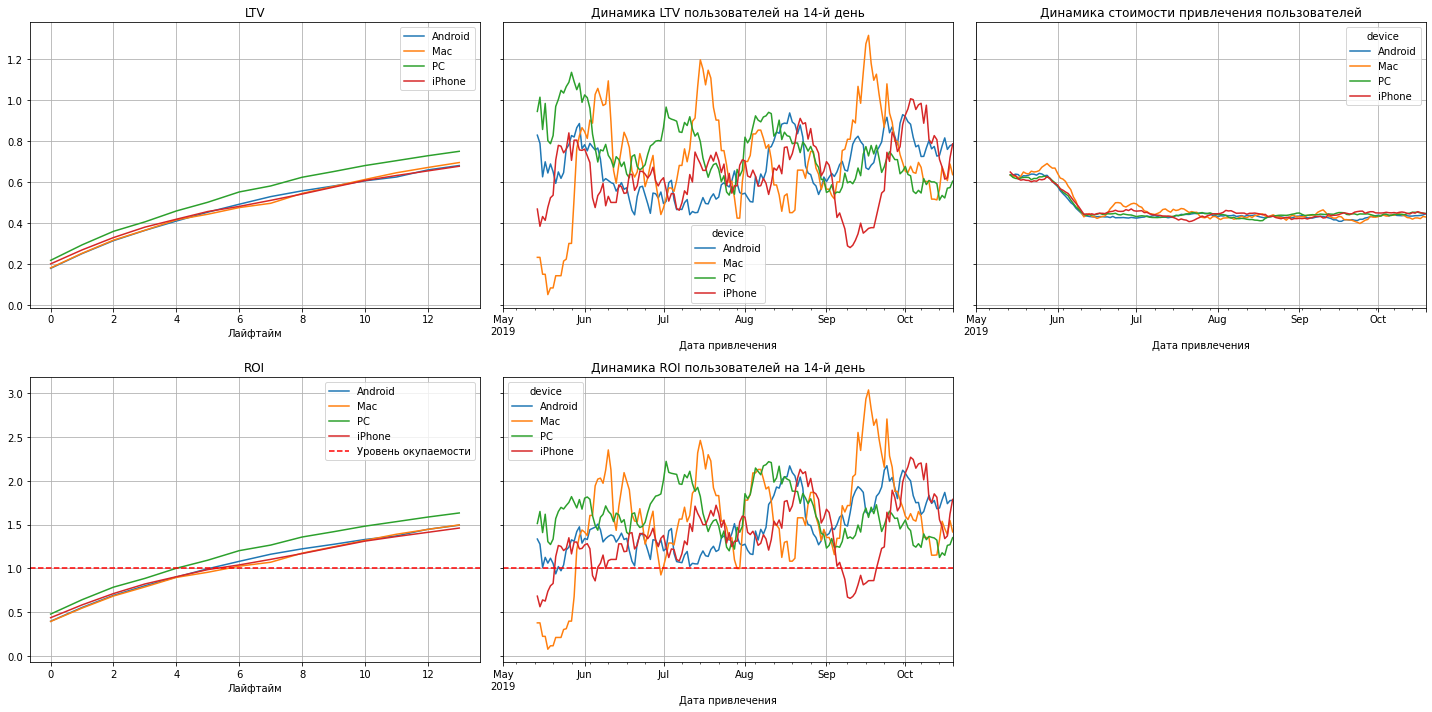

In [61]:
# Посмотрим на окупаемость с разбивкой по устройствам
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_wo_org_europe, orders, observation_date, analysis_horizon, dimensions=['device']
)
plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, analysis_horizon, window=14
) 

По графикам можно сделать вывод, что характер показателей LTV и ROI примерно одинаковый по всем устройствам и нельзя выделить явных лидеров или аутсайдеров на общем фоне. Лишь пользователи на PC на день раньше начинают окупаться.

#### Анализ окупаемости рекламы с разбивкой по рекламным каналам

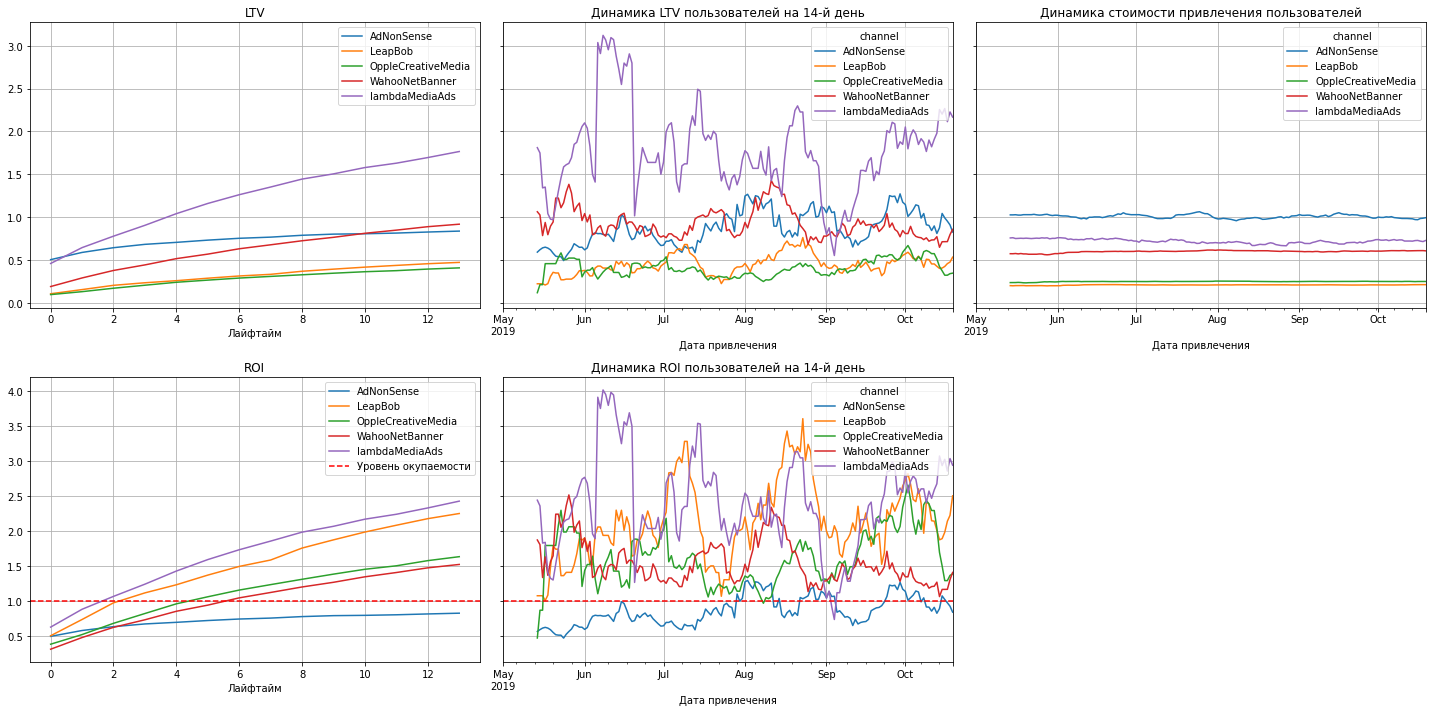

In [62]:
# Посмотрим на окупаемость с разбивкой по источникам привлечения
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_wo_org_europe, orders, observation_date, analysis_horizon, dimensions=['channel']
)
plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, analysis_horizon, window=14
) 

- У пользователей со всех рекламных каналов показатель LTV имеет положительную динамику.
- Стоимость привлечения пользователей у канала AdNonSense самая высокая. 
- Реклама в AdNonSense не окупается.
- Быстрее всего окупается реклама в lambdaMediaAds и LeapBob - на 2й день, а в каналах OppleCreativeMedia и WahooNetBanner - на 5й день.

### Ответы на вопросы
**Окупается ли реклама, направленная на привлечение пользователей в целом?**<br>
В целом реклама не окупается - на 14 день ROI достигает всего 80%

**Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?**
- В разрезе устройств наиболее негативное влияние оказывают пользовотели Mac и iPhone - они имеют самую низкую акупаемость 
и самую высокую стоимость привлечения. Но если рассматривать по отдельности пользователей США и Европы, то видно, что тип устройства никакого влияния не оказывает.
- Привлечение пользователей из США наименее выгодно по сравнению с пользователями из других стран. Но при детальном изучении пользователей из США видно, что картину портят только реклама в TipTop и FaceBoom - только в этих каналах реклама не окупается в США.
- Из каналов привлечения наименее эффективными оказались TipTop, AdNonSense и FaceBoom - реклама в них не окупается,
а реклама в TipTop при этом имеет самую высокую стоимость. Но при отдельном рассмотрении пользователей из США и Евромы мы видим, что в США не окупается реклама в TipTop и FaceBoom, а в Европе - только из AdNonSense.

**Чем могут быть вызваны проблемы окупаемости?**
- Проблемы окупаемости могут быть вызваны техническими ошибками в самом приложении или в интегрированных в него сервисах - 
например в сервисе оплаты или доставки. Подобные ошибки могут быть характерны для отдельных групп пользователей - 
жителей определенных стран или пользователей конкретных типов устройств.
- Так же проблема окупаемости может быть связана с высокой стоимостью рекламы в отдельных каналах.

**Промежуточные рекомендации для рекламного отдела**
- Ограничить бюджет или исключить рекламу для пользователей из США в TipTop и FaceBoom.
- Ограничить бюджет или исключить рекламу для пользователей из Европы в AdNonSense.
- Для пользователей из Европы стоит увеличить бюджет на рекламу в lambdaMediaAds и LeapBob.
- Запросить у технического отдела анализ ошибок в приложении у пользователей из каналов TipTop, FaceBoom и AdNonSense.

### Выводы

- LTV растет на протяжении всего рассматриваемого периода, значит качество пользователей примерно на одном уровне. Это хороший показатель.
- Однако реклама все равно не окупается, и к концу второй недели уровень окупаемости достигает всего лишь 80%
- На графике динамики LTV наблюдаются подъемы и спады, видимо оказывает влияние сезонный фактор
- Показатель САС на протяжении всего периода растет, а показатель ROI снижается
- Первые четыре дня лайфтайма конверсия стремительно растет, затем рост замедляется.  
- В целом конверсия пользователей постепенно растёт на протяжении всего периода и выходит на отметку 8%.
- Конверсия на 14й день в динамике имеет скочкообразный характер, где амплитуда скачков изменяется от 7% до 9% 
- В первый день лайтайма удержание платящих пользователей составляет около 40%. Затем этот показатель падает, и к 14-му дню составляет активных платящих пользоватетей остается лишь 10%. 
- Пик удержания платящих пользователей приходится на июнь 2019 года.
- График удержания неплатящих пользователей показывает, что они практически не задерживаются в приложении.
- LTV по всем устройствам растет на протяжении всего периода
- LTV держателей PC ниже, чем у пользователей с других устройств (если смотреть на динамику LTV), однако только с этого устройства пользователи окупались самый длительный период 
- Самая низкая стоимость привлечения поользователей у владельцев PC устройств
- Дороже всего приложению обходятся пользователи iPhone и по окупаемости у них самый худший показатель
- Рекламные расходы не окупаются лишь в США. Показатель стоимости привлечения пользователей в данной странне самый высокий и постоянно растет, несмотря на то, что это наша основная аудитория (показатель LTV у них самый высокий)
- В  остальных странах показатель САС стабилен, то есть расходы на маркетинг окупаются приблизительно за 5 дней
- Быстрее всего окупаются пользователи из UK - 4 дня, в динамике пик окупаемости пришелся на середину августа
- У пользователей со всех рекламных каналов показатель LTV имеет положительную динамику.
- Стоимость привлечения пользователей у канала TipTop самая высокая. Также данный канал самый худший по показателю окупаемости (ROI), то есть рекламные расходы не окупаются.
- Также не окупаются пользователи, привлеченные из каналов AdNonSense и FaceBoom.
- Лучше всего окупаются пользователи, привлеченные через сеть YRabbit, пик окупаемости приходится на июль
- Для пользователей из США реклама в каналах TipTop и FaceBoom не окупаются
- Для пользователей из Европы реклама в канале AdNonSense не окупается

## Общие выводы

### Обобщение результатов исследования

**На этапе предобработки данных были проведены следующие действия:**
- Названия всех столбцов приведены к единому стилю
- Стобцы с датой приведены к соответствующему типу
- Дубликаты в данных не обнаружены
- Подготовлены функции для дальнейшего анализа данных

**На этапе исследовательского анализа данных были получены следующие результаты:**
- Подготовили профили пользователей
- Минимальная дата привлечения пользователей 2019-05-01, максимальная 2019-10-27
- Большая часть пользователей, которые приходят в приложение, из США - 66,7%. Меньше всего пользоватлей из Германии - 10%
- Платящих пользователей больше всего приходится на США - 77,7%, меньше всего платящих пользователей приходится на Германию - 6,9%
- Чаще всего клиенты используют IPhone - 36,3%, равномерно распределено количество пользователей среди устройств - PC и MAC, по 20%
- Наибольшая доля платящих клиентов у пользователей устройства Mac - 6,36%, наименьшая у PC - 5.05%
- Наибольшее количество пользователей дают каналы organic, FaceBoom и TipTop
- Максимальная конверсия в платящих пользователей приходится на каналы FaceBoom, AdNonSense и lambdaMediaAds

**При исследовании маркетинговых показателей были сделаны следующие выводы:**
- Общая сумма расходов на маркетинг:  $105497.30
- больше всего денег потратили на такие каналы привлечения, как - TipTop и FaceBoom
- затраты на привлечение пользователей с остальных источников оказались гораздо меньше
- минимальный бюджет был выделен на источник "YRabbit"
- компания сделала ставку на привлечение пользователей через каналы TipTop и FaceBoom
- пиковые расходы пришлись на периоды вторая половина июня и сентября
- остальные каналы получили миниммальные бюджеты и траты на них практически не меняются
- Посчитаем средний САС по всем пользователям платных каналов - 1,3
- Самыми дорогими по стоимости оказались пользователи, привлеченные через канал TipTop - средняя цена 2,8 доллар за одного пользователя.
- Практически в одинаковую цену обходятся пользователи, привлеченные через источники FaceBoom и AdNonSense - средняя цена 1,1 и 1 доллар за одного пользователя.
- В самую меньшую стоимость обходятся пользователи, привлеченные через канал LeapBob - 0,21 доллар за одного.

**Анализ окупаемости рекламы показал:**
- LTV растет на протяжении всего рассматриваемого периода, значит качество пользователей примерно на одном уровне. Это хороший показатель.
- Однако реклама все равно не окупается, и к концу второй недели уровень окупаемости достигает всего лишь 80%
- На графике динамики LTV наблюдаются подъемы и спады, видимо оказывает влияние сезонный фактор
- Показатель САС на протяжении всего периода растет, а показатель ROI снижается
- Первые четыре дня лайфтайма конверсия стремительно растет, затем рост замедляется.  
- В целом конверсия пользователей постепенно растёт на протяжении всего периода и выходит на отметку 8%.
- Конверсия на 14й день в динамике имеет скочкообразный характер, где амплитуда скачков изменяется от 7% до 9% 
- В первый день лайтайма удержание платящих пользователей составляет около 40%. Затем этот показатель падает, и к 14-му дню составляет активных платящих пользоватетей остается лишь 10%. 
- Пик удержания платящих пользователей приходится на июнь 2019 года.
- График удержания неплатящих пользователей показывает, что они практически не задерживаются в приложении.
- LTV по всем устройствам растет на протяжении всего периода
- LTV держателей PC ниже, чем у пользователей с других устройств (если смотреть на динамику LTV), однако только с этого устройства пользователи окупались самый длительный период 
- Самая низкая стоимость привлечения поользователей у владельцев PC устройств
- Дороже всего приложению обходятся пользователи iPhone и по окупаемости у них самый худший показатель
- Рекламные расходы не окупаются лишь в США. Показатель стоимости привлечения пользователей в данной странне самый высокий и постоянно растет, несмотря на то, что это наша основная аудитория (показатель LTV у них самый высокий)
- В  остальных странах показатель САС стабилен, то есть расходы на маркетинг окупаются приблизительно за 5 дней
- Быстрее всего окупаются пользователи из UK - 4 дня, в динамике пик окупаемости пришелся на середину августа
- У пользователей со всех рекламных каналов показатель LTV имеет положительную динамику.
- Стоимость привлечения пользователей у канала TipTop самая высокая. Также данный канал самый худший по показателю окупаемости (ROI), то есть рекламные расходы не окупаются.
- Также не окупаются пользователи, привлеченные из каналов AdNonSense и FaceBoom.
- Лучше всего окупаются пользователи, привлеченные через сеть YRabbit, пик окупаемости приходится на июль
- Для пользователей из США реклама в каналах TipTop и FaceBoom не окупаются
- Для пользователей из Европы реклама в канале AdNonSense не окупается

### Причины неэффективности привлечения пользователей

- Причины неэффективного привлечения пользователей могут быть вызваны техническими ошибками в самом приложении или в интегрированных в него сервисах - например в сервисе оплаты или доставки. Подобные ошибки могут быть характерны для отдельных групп пользователей - жителей определенных стран или пользователей конкретных типов устройств.
- Так же проблема окупаемости может быть связана с высокой стоимостью рекламы в нем - ярким примером здесь служит реклама в TipTop.

### Рекомендации для отдела маркетинга

- Ограничить бюджет или исключить рекламу для пользователей из США в TipTop и FaceBoom.
- Ограничить бюджет или исключить рекламу для пользователей из Европы в AdNonSense.
- Запросить у технического отдела анализ ошибок в приложении у пользователей из каналов TipTop, FaceBoom и AdNonSense.
- Для пользователей из Европы стоит поднять бюджет на рекламу в lambdaMediaAds и LeapBob.
